In [1]:
import pandas as pd
import numpy as np
import glob
import os
from scipy import signal
from scipy.stats import gaussian_kde

import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns

In [2]:
mpl.rcParams['axes.linewidth'] = 0.5 #set the value globally
mpl.rcParams['xtick.major.width'] = 0.5
mpl.rcParams['ytick.major.width'] = 0.5
mpl.rcParams['axes.titlesize'] = 10
mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams["lines.linewidth"] = 0.5

mpl.rc('font',**{'family':'sans-serif','serif':['Arial']})
mpl.rcParams['pdf.fonttype'] = 42

In [3]:
def GetAllUsableData(data, v):
    visit = v
    df = pd.DataFrame([])
    for eachfile in data:
        tail = os.path.basename(eachfile)
        n = segments = tail.split("_")
        name = n[0] + '_' + n[1]
        
        temp = pd.read_csv(eachfile)

#         if np.any(subset.names == name):
        p1 = pd.Series(data = [name] * len(temp), name = 'name')
        p2 = pd.Series(data = [visit] * len(temp), name = 'visit')

        temp1 = pd.concat([temp, p1, p2], axis = 1)

        df = df.append(temp1)
        df = df[(df.radial_distance_normalized.notnull()) & (df.angle.notnull())]
    return(df)

In [4]:
def FitGaussainKde(radialDist, RRO):
        m1 = radialDist
        m2 = RRO
        xmin = m1.min()
        xmax = m1.max()
        ymin = m2.min()
        ymax = m2.max()
        X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

        values = np.vstack([m1, m2])
        kernel = gaussian_kde(values)
        
        return(X,Y,kernel)

In [5]:
def getFlowerCurvature(curve, x):
    
    r = 1
    R = 25
    L = 15
    y = L*(((x - r)/R) ** np.exp(curve))
    return y

## draw the radial and angle distribution together

## plot each data axes separately

In [6]:
def accesorise(axes, tickY, tickX):
    axes.spines['left'].set_visible(True)
    axes.spines['bottom'].set_visible(True)
    axes.spines['right'].set_visible(False)
    axes.spines['top'].set_visible(False)
    
    axes.spines['left'].set_smart_bounds(True)
    axes.spines['bottom'].set_smart_bounds(True)

    if tickY:
        axes.set_yticks([0, 45, 90])
        axes.set_yticklabels([0, 45, 90])
    else:
        axes.set_yticks([])
        
    if tickX:
        axes.set_xticks([0, 1])
        axes.set_xticklabels([0, 1])
    else:
        axes.set_xticks([])

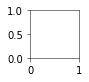

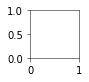

In [7]:
w = (3.5/4) # square-ish figure: 4 rows 4 columns - one column width for paper
f1, ax1 = plt.subplots(figsize = (w,w), num = 'hexbin')
f2, ax2 = plt.subplots(figsize = (w,w), num = 'pde')

In [8]:
outpath = r"../dataFolders/PaperPipelineOutput/Figures/v3/Paper/"
shapes = ['c-1_', 'c-2_', 'c-3_', 'c-10_']
visitnum = ['FirstVisit/','Later7thVisit/' , 'Later20thVisit/']

In [19]:
for vv, visit in enumerate(visitnum):
    data_path = os.path.join(r"../dataFolders/PaperPipelineOutput/v3/RadiusAndAngle/", visit)
    data = glob.glob(data_path +'*.csv')
    
#     videoselection = pd.read_csv(os.path.join(r"../dataFolders/PaperPipelineOutput/FilteredTracks/",visit) + 
#                                           "AllVideoNames.csv")
#     subset = videoselection.loc[videoselection.AutomatatedTracking == 'TRUE', :]
    
#     df = GetAllUsableData(data, subset, visit)
    df = GetAllUsableData(data, visit)
    
    # remove anything greater than 1.5 and less than 0.1
    df = df[(df.radial_distance_normalized < 1.5)
        & (df.radial_distance_normalized > 0.06)]
    
    # print stats of numbers for paper
    print(visit)
    
    for ss, shape in enumerate(shapes):
        r = df.loc[(df.name.str.contains(shape)) & 
                             (df.visit == visit), 'radial_distance_normalized']
        angle = df.loc[(df.name.str.contains(shape)) & 
                             (df.visit == visit), 'angle']
        
        # print stats for paper
        print(shape)
        print('num of frames: {:d}'.format(len(r)))
        numMoths = len(df[(df.name.str.contains(shape)) & (df.visit == visit)].name.unique())
        print('num of moths: {:d}'.format(numMoths))
        
#         ax1.hexbin(r, angle)
#         ax1.axvline(x = 1.0, ls = '--', linewidth = 1, color = 'fuchsia')
#         plt.savefig(outpath + 'test.pdf')
        

        # perform a kernel density estimation
        X,Y,kernel = FitGaussainKde(r, angle)
        #reset the kernel bandwidth to make it smaller
        kernel.set_bandwidth(bw_method=kernel.factor / 1.5)
        
        positions = np.vstack([X.ravel(), Y.ravel()])
        Z = np.reshape(kernel(positions).T, X.shape)
        
        tt = ax2.pcolormesh(X, Y, Z.reshape(X.shape)
                            , cmap=plt.cm.cividis
                            , shading = 'gouraud')
        ax2.contour(X, Y, Z.reshape(X.shape), levels = 4 
                    ,cmap = plt.cm.Purples_r
                    , linewidth = 0.5)
        ax2.axvline(x = 1.0, ls = '--', linewidth = 1, color = 'fuchsia')
        ax2.set_xlim(0, 1.5)
                 
        # set up variables to accesorize
        if vv == 2:
            tickX = True
        else:
            tickX = False
            
        if ss == 0:
            tickY = True
        else:
            tickY = False
        
        accesorise(ax1, tickY, tickX)
        accesorise(ax2, tickY, tickX)
        
        figname = shape + visit[:-1]
#         f1.savefig(outpath + 'hexbin_' + figname + '.pdf')
#         ax1.clear()
        f2.savefig(outpath + 'pde_' + figname + '_Sub3_cividis.pdf')
        ax2.clear()

FirstVisit/
c-1_
num of frames: 6796
num of moths: 16


C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:49: UserWarning: The following kwargs were not used by contour: 'linewidth'


c-2_
num of frames: 10086
num of moths: 17
c-3_
num of frames: 10214
num of moths: 22
c-10_
num of frames: 25729
num of moths: 20
Later7thVisit/
c-1_
num of frames: 2278
num of moths: 13
c-2_
num of frames: 2979
num of moths: 16
c-3_
num of frames: 2535
num of moths: 20
c-10_
num of frames: 6729
num of moths: 17
Later20thVisit/
c-1_
num of frames: 1727
num of moths: 8
c-2_
num of frames: 535
num of moths: 5
c-3_
num of frames: 1429
num of moths: 9
c-10_
num of frames: 5526
num of moths: 13


C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in power
  


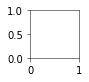

In [34]:
# draw the curvatures
f3, ax3 = plt.subplots(figsize = (w,w))

curvatures = [-1, -2, -3, -10]
x = np.arange(0, 25, 0.1)

for i, c in enumerate(curvatures):
    y = getFlowerCurvature(c, x)
    ax3.plot(x/np.max(x), y, color = 'k', linewidth = 1.0)
    ax3.set_ylim(0, 16)
    ax3.set_xlim(0,1.5)
    f3.savefig(outpath + 'profile_c' + str(c) + '.pdf')
    ax3.clear()

## plot the raw data for the same graph as a separate figure

In [91]:
for axes in first + later7 + later:
    axes.clear()

In [92]:
for visit, axes in zip(visitnum, [first, later7, later]):
    data_path = os.path.join(r"../dataFolders/PaperPipelineOutput/RadiusAndAngle_v2/", visit)
    data = glob.glob(data_path +'*.csv')
    
    videoselection = pd.read_csv(os.path.join(r"../dataFolders/PaperPipelineOutput/FilteredTracks_v2/",visit) + 
                                          "AllVideoNames.csv")
    subset = videoselection.loc[videoselection.AutomatatedTracking == 'TRUE', :]
    
    df = GetAllUsableData(data, subset)
    
    # remove anything greater than 1.5 and less than 0.1
    df = df[(df.radial_distance_normalized < 1.5)
        & (df.radial_distance_normalized > 0.06) ]

    for i, shape in enumerate(shapes):
        r = df.loc[(df.name.str.contains(shape)) & 
                             (df.visit == visit), 'radial_distance_normalized']
        angle = df.loc[(df.name.str.contains(shape)) & 
                             (df.visit == visit), 'angle']

        axes[i].hexbin(r, angle)
        axes[i].axvline(x = 1.0, ls = '--', linewidth = 0.5, color = 'silver')
        axes[i].set_xlim(0, 1.5)
        i+=1

In [93]:
# accesorize

for axes in first + later7 + later:
    axes.spines['left'].set_visible(True)
    axes.spines['bottom'].set_visible(True)
    axes.spines['right'].set_visible(False)
    axes.spines['top'].set_visible(False)
    
    axes.spines['left'].set_smart_bounds(True)
    axes.spines['bottom'].set_smart_bounds(True)

# for axes in [ax30, ax31]:
for axes in [first[0], later7[0], later[0]]:
    axes.set_yticks([0, 45, 90])
    axes.set_yticklabels([0, 45, 90])
    
for axes in later:
    axes.set_xticks([0, 1])
    axes.set_xticklabels([0, 1])
    
for axes in first + later7 + profiles:
    axes.set_xticks([])
    
for axes in first[1:] + later7[1:] + later[1:] + profiles[1:]: 
    axes.set_yticks([])

C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


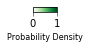

In [20]:
# colorbars

import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt

points = 100 
cmap_hexbin = cm.get_cmap('viridis')
cmap_pdf = cm.get_cmap('Greens')

fig, ax = plt.subplots(figsize=(w/2, w/10))
# fig.subplots_adjust(bottom=0.5)

cmap = cmap_hexbin
# norm = mpl.colors.Normalize(vmin=(framestrt - lagPoints)/100, vmax= framestrt/100)

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
#                                 norm=norm,
                                orientation='horizontal')
cb1.set_label('Normalized count')
fig.show()
plt.savefig('../dataFolders/PaperPipelineOutput/Figures/v3/Paper/colorbar_hexbin-v1.pdf')

cmap = cmap_pdf
cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
#                                norm=norm,
                               orientation='horizontal')
cb2.set_label('Probability Density')
plt.savefig('../dataFolders/PaperPipelineOutput/Figures/v3/Paper/colorbar_2Dpdf-v1.pdf')

In [131]:
# # accesorize

# for axes in first + later:
#     axes.spines['left'].set_visible(True)
#     axes.spines['bottom'].set_visible(True)
#     axes.spines['right'].set_visible(False)
#     axes.spines['top'].set_visible(False)
    
#     axes.spines['left'].set_smart_bounds(True)
#     axes.spines['bottom'].set_smart_bounds(True)

# for axes in [ax30, ax31]:
#     axes.set_xticks([0, 45, 90])
#     axes.set_xticklabels([0, 45, 90])
    
# for axes in first:
#     axes.set_yticks([0, 1])
#     axes.set_yticklabels([0, 1])
    
# for axes in first[:-1] + later[:-1] + profiles[:-1]:
#     axes.set_xticks([])
    
# for axes in later + profiles: 
#     axes.set_yticks([])

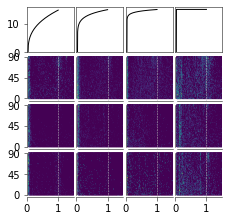

In [94]:
f

In [95]:
f.savefig(r"../dataFolders/PaperPipelineOutput/Figures/v2/Paper/Figure4-angleVsRRO_rawDatav0-3.pdf")

In [6]:
# ## draw Fig3 in its entirity - vertical aligned for shape

# shapes = ['c-1', 'c-2','c-3', 'c-10']
# w = 3.5 # half width 
# h = 4.67 # square-ish figure

# # gridspec inside gridspec
# f = plt.figure(figsize = (w,h))

# gs0 = plt.GridSpec(4, 5, figure=f, hspace = 0.05, wspace=0.05)

# ax00 = f.add_subplot(gs0[0,0:2])
# ax10 = f.add_subplot(gs0[1,0:2])
# ax20 = f.add_subplot(gs0[2,0:2])
# ax30 = f.add_subplot(gs0[3,0:2])

# ax01 = f.add_subplot(gs0[0,2:4])
# ax11 = f.add_subplot(gs0[1,2:4])
# ax21 = f.add_subplot(gs0[2,2:4])
# ax31 = f.add_subplot(gs0[3,2:4])

# ax02 = f.add_subplot(gs0[0,4])
# ax12 = f.add_subplot(gs0[1,4])
# ax22 = f.add_subplot(gs0[2,4])
# ax32 = f.add_subplot(gs0[3,4])

In [7]:
# ## draw Fig3 in its entirity - horizontally aligned for shape

# shapes = ['c-1', 'c-2','c-3', 'c-10']
# w = 3.5 # half width 
# h = (3.5/4)*4 # square-ish figure

# # gridspec inside gridspec
# f = plt.figure(figsize = (w,h))

# gs0 = plt.GridSpec(4, 4, figure=f, hspace = 0.05, wspace=0.05)

# axf0 = f.add_subplot(gs0[0,0])
# axf1 = f.add_subplot(gs0[0,1])
# axf2 = f.add_subplot(gs0[0,2])
# axf3 = f.add_subplot(gs0[0,3])

# axv00 = f.add_subplot(gs0[1,0])
# axv01 = f.add_subplot(gs0[1,1])
# axv02 = f.add_subplot(gs0[1,2])
# axv03 = f.add_subplot(gs0[1,3])

# axv10 = f.add_subplot(gs0[2,0])
# axv11 = f.add_subplot(gs0[2,1])
# axv12 = f.add_subplot(gs0[2,2])
# axv13 = f.add_subplot(gs0[2,3])

# axv20 = f.add_subplot(gs0[3,0])
# axv21 = f.add_subplot(gs0[3,1])
# axv22 = f.add_subplot(gs0[3,2])
# axv23 = f.add_subplot(gs0[3,3])

In [8]:
# first = [axv00, axv01, axv02, axv03]
# later7 = [axv10, axv11, axv12, axv13]
# later = [axv20, axv21, axv22, axv23]
# profiles = [axf0, axf1, axf2, axf3]

In [86]:
# shapes = ['c-1_', 'c-2_', 'c-3_', 'c-10_']

# visitnum = ['FirstVisit/','Later7thVisit/' , 'LaterVisit/']

# for visit, axes in zip(visitnum, [first, later7, later]):
#     data_path = os.path.join(r"../dataFolders/PaperPipelineOutput/RadiusAndAngle_v2/", visit)
#     data = glob.glob(data_path +'*.csv')
    
#     videoselection = pd.read_csv(os.path.join(r"../dataFolders/PaperPipelineOutput/FilteredTracks_v2/",visit) + 
#                                           "AllVideoNames.csv")
#     subset = videoselection.loc[videoselection.AutomatatedTracking == 'TRUE', :]
    
#     df = GetAllUsableData(data, subset)
    
#     # remove anything greater than 1.5 and less than 0.1
#     df = df[(df.radial_distance_normalized < 1.5)
#         & (df.radial_distance_normalized > 0.06)]

#     for i, shape in enumerate(shapes):
#         r = df.loc[(df.name.str.contains(shape)) & 
#                              (df.visit == visit), 'radial_distance_normalized']
#         angle = df.loc[(df.name.str.contains(shape)) & 
#                              (df.visit == visit), 'angle']

# #         ax[i].hexbin(r, angle)
# #         ax[i].set_title(shape + 'radial Dist vs angle')

#         # perform a kernel density estimation
#         X,Y,kernel = FitGaussainKde(r, angle)
#         #reset the kernel bandwidth to make it smaller
#         kernel.set_bandwidth(bw_method=kernel.factor / 1.5)
        
#         positions = np.vstack([X.ravel(), Y.ravel()])
#         Z = np.reshape(kernel(positions).T, X.shape)

#         tt = axes[i].pcolormesh(X, Y, Z.reshape(X.shape), cmap=plt.cm.BuGn_r)
        
# #         # get colorbar
        
# #         cbar = fig.colorbar(tt, ax=ax0)
#         axes[i].contour(X, Y, Z.reshape(X.shape), levels = 4, linewidth = 0.5)
#         axes[i].axvline(x = 1.0, ls = '--', linewidth = 0.5, color = 'fuchsia')
#         axes[i].set_xlim(0, 1.5)
#         i+=1

C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:41: UserWarning: The following kwargs were not used by contour: 'linewidth'


In [7]:
# curvatures = [-1, -2, -3, -10]
# x = np.arange(0, 25, 0.1)

# for i, c in enumerate(curvatures):
#     y = getFlowerCurvature(c, x)
#     profiles[i].plot(x/np.max(x), y, color = 'k', linewidth = 1.0)
#     profiles[i].set_ylim(0, 16)
#     profiles[i].set_xlim(0,1.5)

In [8]:
# # accesorize

# for axes in first + later7 + later:
#     axes.spines['left'].set_visible(True)
#     axes.spines['bottom'].set_visible(True)
#     axes.spines['right'].set_visible(False)
#     axes.spines['top'].set_visible(False)
    
#     axes.spines['left'].set_smart_bounds(True)
#     axes.spines['bottom'].set_smart_bounds(True)

# # for axes in [ax30, ax31]:
# for axes in [first[0], later7[0], later[0]]:
#     axes.set_yticks([0, 45, 90])
#     axes.set_yticklabels([0, 45, 90])
    
# for axes in later:
#     axes.set_xticks([0, 1])
#     axes.set_xticklabels([0, 1])
    
# for axes in first + later7 + profiles:
#     axes.set_xticks([])
    
# for axes in first[1:] + later7[1:] + later[1:] + profiles[1:]: 
#     axes.set_yticks([])

In [9]:
# f

In [10]:
# f.savefig(r"../dataFolders/PaperPipelineOutput/Figures/v2/Paper/Figure4-angleVsRRO_v0-3.pdf")